In [1]:
import os
import gc
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import imageio
import shutil
import random

from src.hVOS.camera import Camera
from cam_params import cam_params
from src.hVOS.optical_roi import BaselineCorrection


In [2]:
data_dir = 'C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/'


In [ ]:
# which pixel is the stim?
fov_center = cam_params['cam_fov'] 
cam_width = cam_params['cam_width']
cam_height = cam_params['cam_height'] 
is_stim_at_cam_center = cam_params['xstim_at_cam_fov']
cam = Camera([], [], [], init_dummy=True, fov_center=fov_center,
             cam_width=cam_width, cam_height=cam_height)  # dummy camera to get pixel coords
print(cam.map_point_to_pixel(fov_center[0], fov_center[1], fov_center[2]))

In [3]:
# load time
t_max = 999
delta_t = 0.1
time = np.arange(0, t_max * delta_t, delta_t)
cam_width = cam_params['cam_width']
cam_height = cam_params['cam_height']
# set random seed
random.seed(4322)

# input: expects a directory 'analyze_output' with the output_dir_#.tar.gz files
output_dir = data_dir + 'composed_output/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
should_re_extract = True  # set to True if you want to re-extract the data into existing folders

############################################
# create a 2-d gaussian PSF with a sigma of 1.5 pixels
############################################
psf_2d = np.zeros((7, 7))
for i in range(7):
    for j in range(7):
        psf_2d[i, j] = np.exp(-((i - 3) ** 2 + (j - 3) ** 2) / (2 * 1.5 ** 2))

# normalize the PSF
psf_2d /= np.sum(psf_2d)

In [4]:
print(cam_params)

{'cam_width': 200, 'cam_height': 200, 'cam_resolution': 3.0, 'cam_fov': [185.0, 800.0, 164.0], 'xstim_at_cam_fov': True}


In [5]:


################################################
# Extract the tar.gz file (result from optical model)
# map files and collect data into composed arrays of all cells
# Delete files as possible to free up disk space
################################################
comparts = ['axon', 'dend', 'soma', 'apic']
all_cells_rec = {
    p: { 
        c: {
            'syn': None,
            'spk': None,
        } for c in comparts
    } for p in ['no_psf', 'psf']
}

# sparsity titration
biological_sparsity = 1.0  # when sparsity == 1.0, the biological sparsity is 0.6
sparsity_range = [0.2, 0.3, 0.5, 0.7, 0.9, 1.0]

# soma:dend expression ratio titration
soma_dend_ratio_default = 0.5  # if no coefficient applied, this is the actual ratio (allows upscaling)
soma_dend_ratio_range = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

# actual soma dend ratio
soma_dend_ratio_range_factor = [sd_ratio / soma_dend_ratio_default for sd_ratio in soma_dend_ratio_range]

sparsity_soma_ratio_arr = [[np.zeros((cam_width, cam_height), dtype='float32')
                        for _ in range(len(soma_dend_ratio_range))]
                        for _ in range(len(sparsity_range))]

five_soma_masks = []  # for later analysis
output_dir_dict = {}
for file in os.listdir(data_dir):
    if file.endswith('.tar.gz') and 'output_dir_' in file:
        i_output = file.replace(".tar.gz", "").split("_")[-1]
        if i_output == '':
            continue
        i_output = int(i_output)
        
        output_dir_extract = data_dir + file[:-7] + '/'
        print(data_dir + file)
        if not os.path.exists(output_dir_extract) or should_re_extract:
            if not os.path.exists(output_dir_extract):
                print("\tCreating directory:", output_dir_extract)
                os.makedirs(output_dir_extract)
            result = subprocess.run(['tar', '-xzvf', data_dir + file, "-C", output_dir_extract], 
                                    capture_output=True, text=True, check=True)
        
        input_dirs = []
        for subdir in os.listdir(output_dir_extract + 'analyze_output/model_rec_final/'):
            print(subdir)
            if 'cell' in subdir:
                cell_id = 'cell_' + subdir.split('cell_')[1]

                output_dir_dict[cell_id] = output_dir_extract + 'analyze_output/model_rec_final/' + subdir + '/'
                input_dirs.append(output_dir_dict[cell_id])

        ################################################
        for input_dir in input_dirs:
            if not os.path.exists(input_dir):
                print(f"input_dir {input_dir} does not exist. Skipping.")
                continue

            # roll the sparsity dice for this cell. rand float between 0 and 1
            sparsity_dice_rolls = [
                random.random() < sparse for sparse in sparsity_range
            ]
            for file in os.listdir(input_dir):
                if file.endswith('.npy'):
                    # open numpy memmap file 
                    file_path = input_dir + file
                    print("Storing from", file_path)
                    arr = np.memmap(file_path, dtype='float32', mode='r').reshape(-1, cam_width, cam_height)

                    # use the file name to determine the compartment and type of data
                    # e.g. no_psf_cell_8406-syn_rec_dend.npy
                    # e.g. psf_cell_8406-spk_rec_soma.npy
                    # e.g. psf_cell_8406-syn_rec_apic.npy
                    compart_type = file.split("_")[-1].replace(".npy", "")
                    psf_type = file.split("_")[0]
                    psf_type = 'no_psf' if psf_type == 'no' else 'psf'
                    activity_type = file.split("_")[-3]
                    activity_type = activity_type.split("-")[1]
                    cell_id = file.split("_")[1].split("-")[0]

                    # sparsity data collection
                    for i_sp in range(len(sparsity_range)):
                        if sparsity_dice_rolls[i_sp]:
                            for i_sr in range(len(soma_dend_ratio_range)):
                                # attenuate the data by the soma:dend ratio if this is a soma compartment
                                sparsity_soma_ratio_arr[i_sp][i_sr] += np.max(arr, axis=0) * \
                                    (soma_dend_ratio_range_factor[i_sr] if 'soma' in compart_type else 1.0)

                    print(compart_type, psf_type, activity_type, cell_id)

                    if all_cells_rec[psf_type][compart_type][activity_type] is None:
                        all_cells_rec[psf_type][compart_type][activity_type] = \
                            np.zeros(arr.shape, dtype='float32')
                    
                    all_cells_rec[psf_type][compart_type][activity_type] += arr

                    if len(five_soma_masks) < 5:
                        if compart_type == 'soma' and activity_type == 'syn' and psf_type == 'no_psf':
                            if np.sum(np.abs(arr)) > 0:
                                # take the first 5 masks
                                five_soma_masks.append(np.max(arr, axis=0))
                    del arr
                    gc.collect()
            
            # delete the input_dir to free up space
            try:
                shutil.rmtree(input_dir)
            except Exception as e:
                print(f"Error deleting {input_dir}: {e}")

C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/output_dir_0.tar.gz
	Creating directory: C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/output_dir_0/
cell_9880
signal.png
Storing from C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/output_dir_0/analyze_output/model_rec_final/cell_9880/no_psf_cell_9880-syn_rec_apic.npy
apic no_psf syn psf
Storing from C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/output_dir_0/analyze_output/model_rec_final/cell_9880/no_psf_cell_9880-syn_rec_axon.npy
axon no_psf syn psf
Storing from C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/output_dir_0/analyze_output/model_rec_final/cell_9880/no_psf_cell_9880-syn_rec_dend.npy
dend no_psf syn psf
Storing from C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/output_dir_0/analyze_output/model_rec_final/cell_9880/no_psf_cell_9880-syn_rec_soma.npy
soma no_psf syn psf
C:/Users/jjudge3/Desktop/neuron docker/composed_results/

In [6]:
all_cells_rec

{'no_psf': {'axon': {'syn': array([[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          ...,
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           

In [7]:


###########################################
# Show each result in all_cells_rec and save in output_dir
###########################################
# finally, show each of the results in all_cells_rec
for psf_type in all_cells_rec.keys():
    composed_arr = None
    for compart_type in all_cells_rec[psf_type].keys():
        for activity_type in all_cells_rec[psf_type][compart_type].keys():
            arr = all_cells_rec[psf_type][compart_type][activity_type]
            if arr is None:
                continue
            if composed_arr is None:
                composed_arr = np.zeros(arr.shape, dtype='float32')
            composed_arr += arr

            if psf_type == 'psf':
                plt.clf()
                plt.imshow(-arr[0, :, :], cmap='hot', interpolation='nearest')
                plt.colorbar()
                plt.title(f"{psf_type} {compart_type} {activity_type}")
                plt.savefig(output_dir + f"{psf_type}_{compart_type}_{activity_type}_psf.png")
            elif psf_type == 'no_psf':
                # show it side-by-side with the image blurred with the PSF
                # blur the image with the PSF
                blurred_arr = np.zeros(arr.shape, dtype='float32')
                for i in range(arr.shape[0]):
                    blurred_arr[i, :, :] = signal.convolve2d(arr[i, :, :], psf_2d, mode='same')
                plt.clf()
                plt.subplot(1, 2, 1)
                plt.imshow(-arr[0, :, :], cmap='hot', interpolation='nearest')
                plt.title(f"{psf_type} {compart_type} {activity_type}")
                plt.subplot(1, 2, 2)
                plt.imshow(-blurred_arr[0, :, :], cmap='hot', interpolation='nearest')
                plt.title(f"{psf_type} {compart_type} {activity_type} blurred")
                plt.savefig(output_dir + f"{psf_type}_{compart_type}_{activity_type}_blurred.png")

                # save the blurred image

    if composed_arr is None:
        continue
    # show composed_arr
    plt.clf()
    plt.imshow(-composed_arr[0, :, :], cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.savefig(output_dir + f"{psf_type}_composed.png")

    if psf_type == 'no_psf':
        blurred_composed_arr = np.zeros(composed_arr.shape, dtype='float32')
        for i in range(composed_arr.shape[0]):
            blurred_composed_arr[i, :, :] = signal.convolve2d(composed_arr[i, :, :], psf_2d, mode='same')
        plt.clf()
        plt.imshow(-blurred_composed_arr[0, :, :], cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.savefig(output_dir + f"blurred_composed.png")

make_movies = True

###############################################
# make each array into an animated gif using Camera.animate_frames_to_video
###############################################
cam = Camera([], [], time, init_dummy=True)
final_arr =  {}
for psf_type in all_cells_rec.keys():
    for compart_type in all_cells_rec[psf_type].keys():
        for activity_type in all_cells_rec[psf_type][compart_type].keys():
            print(psf_type, compart_type, activity_type)
            arr = all_cells_rec[psf_type][compart_type][activity_type]
            gif_filename = output_dir + f"{psf_type}_{compart_type}_{activity_type}.gif"
            if arr is None:
                continue
            if make_movies:
                cam.animate_frames_to_video(arr, gif_filename, frames=(400, t_max),
                                            flip=True)

            if psf_type == 'no_psf':
                # blur the image with the PSF
                blurred_arr = np.zeros(arr.shape, dtype='float32')
                for i in range(arr.shape[0]):
                    blurred_arr[i, :, :] = signal.convolve2d(arr[i, :, :], psf_2d, mode='same')
                if make_movies:
                    cam.animate_frames_to_video(blurred_arr, gif_filename.replace('.gif', '_blurred.gif'), 
                                                frames=(400, t_max), flip=True)

            # store the arr
            if psf_type not in final_arr:
                final_arr[psf_type] = {}
            if compart_type not in final_arr[psf_type]:
                final_arr[psf_type][compart_type] = {}
            if activity_type not in final_arr[psf_type][compart_type]:
                final_arr[psf_type][compart_type][activity_type] = {}
            final_arr[psf_type][compart_type][activity_type] = arr

            if psf_type == 'no_psf':
                if 'blurred_arr' not in final_arr:
                    final_arr['blurred_arr'] = {}
                if compart_type not in final_arr['blurred_arr']:
                    final_arr['blurred_arr'][compart_type] = {}
                if activity_type not in final_arr['blurred_arr'][compart_type]:
                    final_arr['blurred_arr'][compart_type][activity_type] = {}

                final_arr['blurred_arr'][compart_type][activity_type] = blurred_arr


print(final_arr.keys())
###############################################
# build final composed as well
###############################################
final_composed_arr = {}
for psf_type in final_arr.keys():
    if psf_type not in final_composed_arr:
        final_composed_arr[psf_type] = None
    for compart_type in final_arr[psf_type].keys():
        for activity_type in final_arr[psf_type][compart_type].keys():
            arr = final_arr[psf_type][compart_type][activity_type]
            if final_composed_arr[psf_type] is None:
                final_composed_arr[psf_type] = np.zeros(arr.shape, dtype='float32')
            final_composed_arr[psf_type] += (-arr)

if make_movies:
    ##################################################
    # make a gif of the final composed arr (blurred)
    ###############################################
    cam.animate_frames_to_video(final_composed_arr['blurred_arr'], 
        output_dir + "final_composed_blurred.gif", frames=(400, t_max),
        flip=True)

    ###############################################
    # build 4 hisograms: # pixels for % compartment contribution for each compartment
    # for each of the 4 compartments
    # 1. get the max amp for each compartment
    # 2. get the sum of the max amps for each compartment
    # 3. get the % contribution for each compartment
    # 4. plot the histogram for each compartment
    # 5. save the histogram as a png file
    ###############################################
    t_stride = 10
    for psf_type in final_arr.keys():
        #filter
        if psf_type != 'blurred_arr':
            continue
        images = []
        for t in range(0, len(time), t_stride):
            print("processing t = ", t)
            plt.clf()
            plt.figure(figsize=(10, 6))
            for compart_type in final_arr[psf_type].keys():
                for activity_type in final_arr[psf_type][compart_type]:
                    arr = final_arr[psf_type][compart_type][activity_type]
                    if arr is None:
                        continue

                    as_fraction_arr = arr / final_composed_arr[psf_type]
                    as_fraction_arr[final_composed_arr[psf_type] == 0] = 0

                    # discard elements that are not in the range (0, 1]
                    as_fraction_arr_t = as_fraction_arr[t, :, :]
                    as_fraction_arr_t = as_fraction_arr_t[as_fraction_arr_t > 0]
                    as_fraction_arr_t = as_fraction_arr_t[as_fraction_arr_t <= 1]
                    # get the histogram of the % contribution for each compartment

                plt.hist(as_fraction_arr_t.flatten(), bins=100, 
                        label=compart_type, histtype='step',
                        linewidth=2,)
            plt.title(f" Contributions of each compartment to pixel (t = {time[t]} ms)")
            plt.xlabel("percent contribution")
            plt.legend()
            plt.ylabel("number of pixels")
            # make log y-scale
            plt.yscale('log')
            filename = f"{psf_type}_{compart_type}_percent_contribution_t_" + str(t) + ".png"
            plt.savefig(output_dir + filename)
            plt.close()

            images.append(imageio.imread(output_dir + filename))
        imageio.mimsave(output_dir + f"{psf_type}_{compart_type}_percent_contribution.gif", images)
        



no_psf axon syn
CREATED MOVIE: C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/no_psf_axon_syn.gif
CREATED MOVIE: C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/no_psf_axon_syn_blurred.gif
no_psf axon spk
no_psf dend syn
CREATED MOVIE: C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/no_psf_dend_syn.gif
CREATED MOVIE: C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/no_psf_dend_syn_blurred.gif
no_psf dend spk
no_psf soma syn
CREATED MOVIE: C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/no_psf_soma_syn.gif
CREATED MOVIE: C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/no_psf_soma_syn_blurred.gif
no_psf soma spk
no_psf apic syn
CREATED MOVIE: C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/no_psf_apic_syn.gif
CREATED MOVIE: C:/Users/jjudge3/Desktop/neuron docker/compo

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  10


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  20


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  30


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  40


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  50


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  60


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  70


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  80


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  90


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  100


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  110


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  120


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  130


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  140


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  150


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  160


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  170


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  180


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  190


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  200


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  210


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  220


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  230


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  240


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  250


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  260


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  270


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  280


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  290


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  300


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  310


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  320


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  330


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  340


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  350


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  360


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  370


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  380


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  390


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  400


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  410


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  420


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  430


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  440


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  450


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  460


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  470


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  480


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  490


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  500


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


processing t =  510


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  520


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  530


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  540


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  550


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  560


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  570


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  580


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  590


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  600


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  610


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  620


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  630


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  640


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  650


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  660


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  670


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  680


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  690


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  700


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  710


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  720


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  730


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  740


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  750


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  760


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  770


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  780


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  790


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  800


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  810


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  820


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  830


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  840


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  850


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  860


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  870


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  880


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  890


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  900


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  910


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  920


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  930


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  940


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  950


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  960


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  970


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  980


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


processing t =  990


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\807040048.py:152: RuntimeWarning: invalid value encountered in true_divide
  as_fraction_arr = arr / final_composed_arr[psf_type]


<Figure size 640x480 with 0 Axes>

In [8]:
all_cells_rec

{'no_psf': {'axon': {'syn': array([[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          ...,
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           

roi_diameter 15
actual roi size 80
roi_diameter 30
actual roi size 708
roi_diameter 29
actual roi size 612
roi_diameter 17
actual roi size 196
roi_diameter 15
actual roi size 148
roi_diameter 26
actual roi size 528
roi_diameter 31
actual roi size 708
roi_diameter 33
actual roi size 796
roi_diameter 28
actual roi size 612
roi_diameter 23
actual roi size 376


<Figure size 640x480 with 0 Axes>

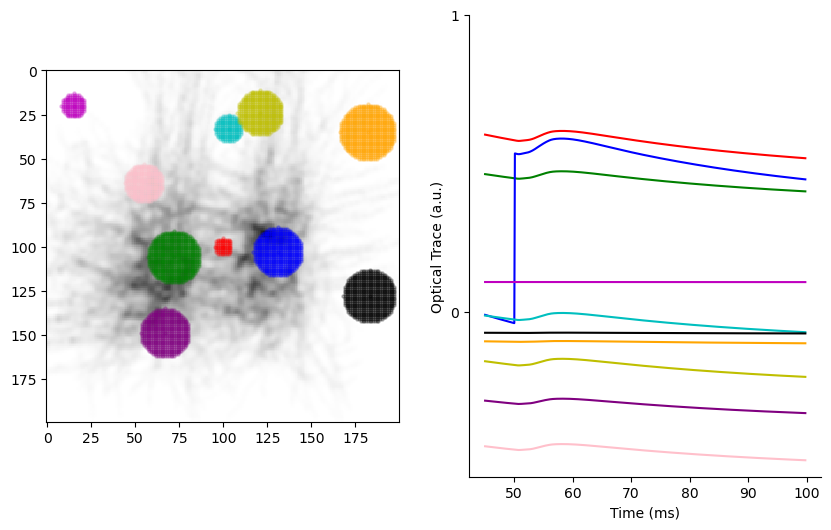

In [9]:

###################################################
# choose random ROIs in the final_composed_arr blurred_arr image 
# and plot their optical traces over time (png)
# Also show location of the ROIs overlaid in the image
###################################################
n_rois = 10
roi_diameter_range = [15, 35]  # size of the ROIs, they are distributed uniformly in size
# matplotlib figure
plt.clf()
plt.figure(figsize=(10, 6))
# show image in left subplot
plt.subplot(1, 2, 1)
plt.imshow(-final_composed_arr['blurred_arr'][0, :, :], 
                cmap='gray', interpolation='nearest')
start_trace = 450
rois = []
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k',
            'orange', 'purple', 'pink']
np.random.seed(7943)  # for reproducibility
for i_roi in range(n_rois):
    roi_diameter = np.random.randint(roi_diameter_range[0], roi_diameter_range[1])
    print('roi_diameter', roi_diameter)
    # random location
    roi_x = np.random.randint(roi_diameter//2, 
                final_composed_arr['blurred_arr'].shape[1] - roi_diameter//2)
    roi_y = np.random.randint(roi_diameter//2,
                final_composed_arr['blurred_arr'].shape[2] - roi_diameter//2)
    if i_roi == 0:
        # use the center of the image for the first ROI
        roi_x = final_composed_arr['blurred_arr'].shape[1] // 2
        roi_y = final_composed_arr['blurred_arr'].shape[2] // 2
        roi_diameter = 10

    roi = [[roi_x, roi_y]]
    roi_map = {}
    # add the roi_size nearest pixels to the roi by spiraling outward until limit reached
    if roi_diameter > 1:
        for i in range(max(0, roi_x-roi_diameter//2), 
                        min(final_composed_arr['blurred_arr'].shape[1], roi_x+roi_diameter//2)):
            for j in range(max(0, roi_y-roi_diameter//2),
                            min(final_composed_arr['blurred_arr'].shape[2], roi_y+roi_diameter//2)):
                if np.sqrt((i - roi_x)**2 + (j - roi_y)**2) <= roi_diameter // 2:
                    if (i, j) not in roi_map:
                        roi.append([i, j])
                        roi_map[(i, j)] = True
    print('actual roi size', len(roi))
    
    # for each pixel in roi, shade the pixel in the image
    for pixel in roi:
        plt.scatter(pixel[0], pixel[1], color=colors[i_roi % len(colors)], s=5,
                    alpha=0.25)
    rois.append(roi)

# now plot the optical trace for each roi
last_headspace = 0
plt.subplot(1, 2, 2)
for i_roi in range(n_rois):
    roi = rois[i_roi]
    roi_trace = None
    for px in roi:
        if roi_trace is None:
            roi_trace = final_composed_arr['blurred_arr'][:, px[0], px[1]]
        else:
            roi_trace += final_composed_arr['blurred_arr'][:, px[0], px[1]]

    roi_trace /= len(roi)
    plt.plot(time[start_trace:] , roi_trace[start_trace:] + last_headspace, 
                color=colors[i_roi % len(colors)])

    last_headspace += roi_trace[start_trace:].min() * 0.5
#plt.xlim(0, 100)
plt.yticks([-1, 0], [0, 1])
#plt.ylim(-2, 0.3)
# spines off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("Time (ms)")
plt.ylabel("Optical Trace (a.u.)")
plt.savefig(output_dir + "roi_traces_no_image.png")
plt.show()
plt.close()

5


<Figure size 640x480 with 0 Axes>

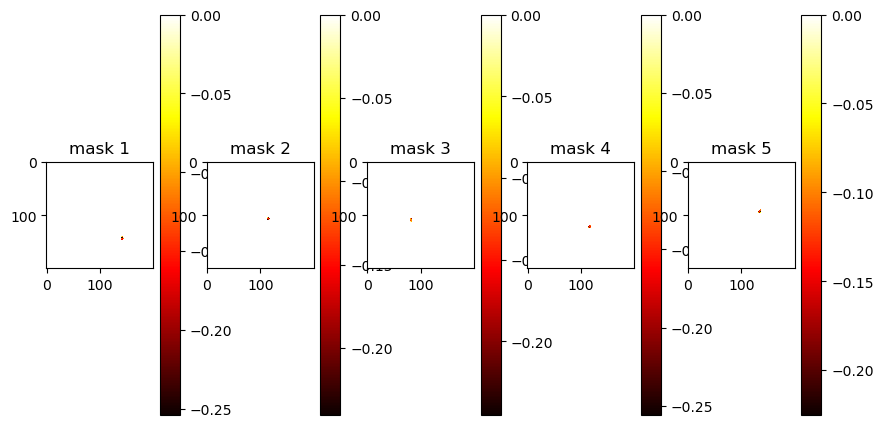

In [10]:
# check five_soma_masks masks
plt.clf()
plt.figure(figsize=(10, 6))
print(len(five_soma_masks))
for i in range(len(five_soma_masks)):
    plt.subplot(1, len(five_soma_masks), i+1)
    plt.imshow(-five_soma_masks[i], cmap='hot', interpolation='nearest')
    plt.title(f"mask {i+1}")
    plt.colorbar()

plt.show()

avg_soma_size 30.6


<Figure size 640x480 with 0 Axes>

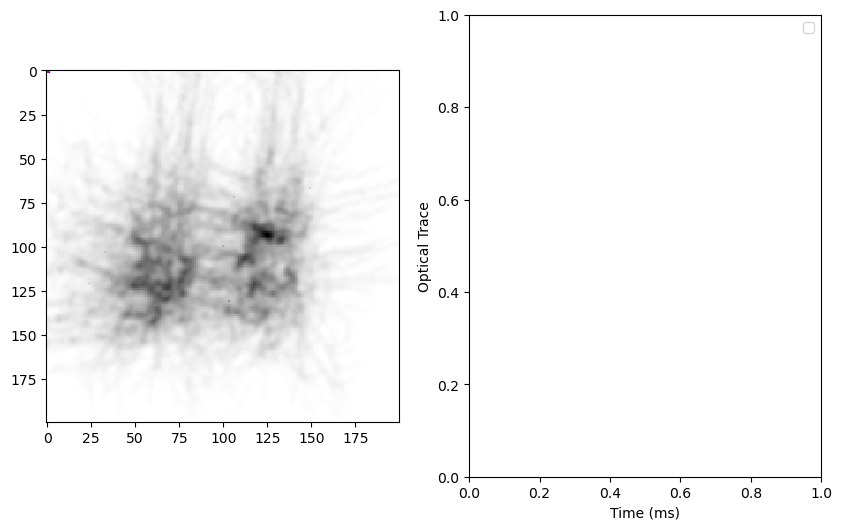

In [11]:
###################################################
# Soma location optical traces versus non-soma
################################################
# use five_soma_masks for non-soma rois
# use all-soma no-psf composition for a mask of all non-soma areas
# and then plot the optical traces for each cell including only pixels inside the mask
# and save the image

all_non_soma = (final_arr['no_psf']['soma']['syn'] == 0)[0, :, :]  # True if not soma
avg_soma_size = np.mean([(mask != 0).sum() for mask in five_soma_masks])
print("avg_soma_size", avg_soma_size)
avg_soma_size = min(np.abs(avg_soma_size), 10)  # default to 10 if way off...
avg_soma_diameter = np.sqrt(avg_soma_size) / np.pi
if np.isnan(avg_soma_diameter) or avg_soma_diameter < 1:
    avg_soma_diameter = 10

five_non_soma_masks = []
for i_non_soma in range(50):
    five_non_soma_masks.append(np.zeros(all_non_soma.shape, dtype=bool))
    # sample a random point from all_non_soma
    non_soma_x = np.random.randint(0, all_non_soma.shape[0])
    non_soma_y = np.random.randint(0, all_non_soma.shape[1])

    for i in range(max(0, int(non_soma_x - avg_soma_diameter // 2)), 
                        min(all_non_soma.shape[0], int(non_soma_x + avg_soma_diameter // 2))):
        for j in range(max(0, int(non_soma_y - avg_soma_diameter // 2)),
                        min(all_non_soma.shape[1], int(non_soma_y + avg_soma_diameter // 2))):
            if abs(i - non_soma_x) + abs(j - non_soma_y) <= avg_soma_diameter // 2:
                if not (i == non_soma_x and j == non_soma_y):
                    if all_non_soma[i, j]:
                        five_non_soma_masks[i_non_soma][i, j] = True
                        all_non_soma[i, j] = True
plt.clf()
plt.figure(figsize=(10, 6))
# show image in left subplot
plt.subplot(1, 2, 1)
plt.imshow(-final_composed_arr['blurred_arr'][0, :, :], 
                cmap='gray', interpolation='nearest')

# plot the rois in the image
for i_roi in range(min(5, len(five_non_soma_masks))):
    roi = five_non_soma_masks[i_roi]
    # for each pixel in roi, shade the pixel in the image
    for pixel in roi:
        plt.scatter(pixel[0], pixel[1], color=colors[i_roi % len(colors)], s=5,
                    alpha=0.25)

# now plot the optical trace for each roi
last_headspace = 0
plt.subplot(1, 2, 2)
leg_handles = []
# plot non-soma traces
for i_soma, five_masks in enumerate([five_non_soma_masks, five_soma_masks]):
    label = "Non-soma"
    color = 'tab:orange'
    l1 = None
    if i_soma == 0:
        label = "Soma"
        color = 'tab:green'
    for i_roi in range(len(five_non_soma_masks)):
        roi_mask = five_non_soma_masks[i_roi]
        roi_trace = None
        for i in range(roi_mask.shape[0]):
            for j in range(roi_mask.shape[1]):
                if roi_mask[i, j]:
                    if roi_trace is None:
                        roi_trace = final_composed_arr['blurred_arr'][:, i, j]
                    else:
                        roi_trace += final_composed_arr['blurred_arr'][:, i, j]
        if roi_trace is None:
            continue
        roi_trace /= -len(roi)
        l1 = plt.plot(time, roi_trace + last_headspace, 
                    color=color,
                    label=label)

        last_headspace += roi_trace.max() * 1.1
    if l1 is not None:
        leg_handles.append(l1[0])


plt.legend(handles=leg_handles, loc='upper right')
plt.xlabel("Time (ms)")
plt.ylabel("Optical Trace")
plt.savefig(output_dir + "dend_v_soma_roi_traces.png")


[0.2, 0.3, 0.5, 0.7, 0.9, 1.0]
[0.9898541433967406, 0.9971365936257828, 0.9940330947274318, 0.9977370717960309, 0.998053426540657, 0.9981879006313568]
[0.2, 0.3, 0.5, 0.7, 0.9, 1.0]
[0.9797109740932808, 0.9942857103150085, 0.9880721974418224, 0.9954892381225461, 0.9961178097112219, 0.9963867038750405]
[0.2, 0.3, 0.5, 0.7, 0.9, 1.0]
[0.8986608002665106, 0.9719135219206578, 0.9405955766986921, 0.9780259085341072, 0.9810134552863019, 0.9823553732995732]
[0.2, 0.3, 0.5, 0.7, 0.9, 1.0]
[0.7975788465447758, 0.9449653012799398, 0.8817504536836651, 0.9573912781119956, 0.9630237103725768, 0.9656993528932729]
[0.2, 0.3, 0.5, 0.7, 0.9, 1.0]
[0.37479886022489517, 0.7596256432886637, 0.6394674420904459, 0.8256946169941048, 0.8457795986870836, 0.8585943390530808]
[0.2, 0.3, 0.5, 0.7, 0.9, 1.0]
[0.18077522316320846, 0.5746033213073811, 0.5102148491503149, 0.7085985526511855, 0.7413182895718874, 0.7650596013779662]
[[[0.9736772098093823, 0.9946589114943867, 0.9874275510902432, 0.9968740328141978, 0.99

<Figure size 640x480 with 0 Axes>

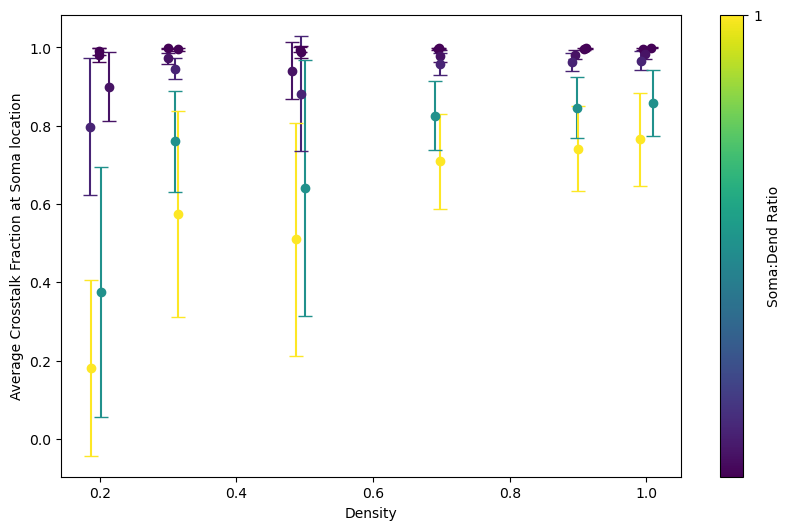

In [12]:

##################################################
# Sparsity analysis: single-cell crosstalk
###############################################
# convolve each of the sparse images

for i_sp in range(len(sparsity_range)):
    for i_sr in range(len(soma_dend_ratio_range)):
        sparsity_soma_ratio_arr[i_sp][i_sr][:, :] = \
            signal.convolve2d(sparsity_soma_ratio_arr[i_sp][i_sr][:, :], psf_2d, mode='same')
crosstalk_fractions = [[[] for _ in range(len(soma_dend_ratio_range))]
                        for _ in range(len(sparsity_range))]
for i_sp, sparsity in enumerate(sparsity_range):
    for i_sr, soma_dend_ratio in enumerate(soma_dend_ratio_range_factor):
        # reconduct the same compose analysis but only sampling SPARSITY % of the cells

        # use the five_soma_masks to analyze the crosstalk
        # at each soma roi, get the fraction of the signal that is from the cell
        # whose soma resides there divided by the total signal from all cells.
        for soma_max in five_soma_masks:
            # get the signal from all cells in the soma mask
            soma_mask = (soma_max != 0)
            cell_soma_signal = -signal.convolve2d(
                        soma_max, 
                        psf_2d, mode='same') * soma_mask
            all_signal = sparsity_soma_ratio_arr[i_sp][i_sr] * soma_mask
            '''plt.clf()
            plt.imshow(sparsity_soma_ratio_arr[i_sp][i_sr] * soma_mask, cmap='hot', interpolation='nearest')
            plt.title(str(np.sum(cell_soma_signal) * soma_dend_ratio) + " / " + str(np.sum(all_signal)))
            plt.show()
            '''
            
            # get the signal from the cell whose soma resides there
            
            # get the crosstalk fraction
            if np.sum(all_signal) != 0:
                crosstalk_fraction = \
                    min(1, np.abs(np.sum(cell_soma_signal)) * soma_dend_ratio / np.sum(all_signal))
                crosstalk_fractions[i_sp][i_sr].append(1-crosstalk_fraction)

bio_sparsity = [biological_sparsity * sp for sp in sparsity_range]
crosstalk_fractions_std = [[np.std(crosstalk_fractions[x_sp][x_sr]) for x_sr in range(len(soma_dend_ratio_range))]
                        for x_sp in range(len(sparsity_range))]
crosstalk_fractions_mean = [[np.mean(crosstalk_fractions[x_sp][x_sr]) for x_sr in range(len(soma_dend_ratio_range))]
                        for x_sp in range(len(sparsity_range))]
# plot average crosstalk fraction verssus sparsity
plt.clf()
plt.figure(figsize=(10, 6))
# scatter plot with error bars
for i_sr, soma_dend_ratio in enumerate(soma_dend_ratio_range):

    # get a color mapping for the soma_dend_ratio
    color = plt.cm.viridis(soma_dend_ratio / (max(soma_dend_ratio_range) - min(soma_dend_ratio_range)))
    print(bio_sparsity)
    print([crosstalk_fractions_mean[x_sp][i_sr] for x_sp in range(len(bio_sparsity))])
    x_jitter = np.random.normal(0, 0.01, len(bio_sparsity))
    plt.errorbar(bio_sparsity + x_jitter, 
                 [crosstalk_fractions_mean[x_sp][i_sr] for x_sp in range(len(bio_sparsity))], 
                yerr=[crosstalk_fractions_std[x_sp][i_sr] for x_sp in range(len(bio_sparsity))], 
                fmt='o',
                 label=f"{soma_dend_ratio}", color=color, capsize=5)

# colorbar for the soma_dend_ratio
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(min(soma_dend_ratio_range), max(soma_dend_ratio_range)))
sm.set_array([])
plt.colorbar(sm, ticks=range(len(soma_dend_ratio_range)), label='Soma:Dend Ratio')

plt.xlabel("Density")
plt.ylabel("Average Crosstalk Fraction at Soma location")
plt.savefig(output_dir + "crosstalk_sparsity.png")
print(crosstalk_fractions)
print(crosstalk_fractions_std)


<Figure size 640x480 with 0 Axes>

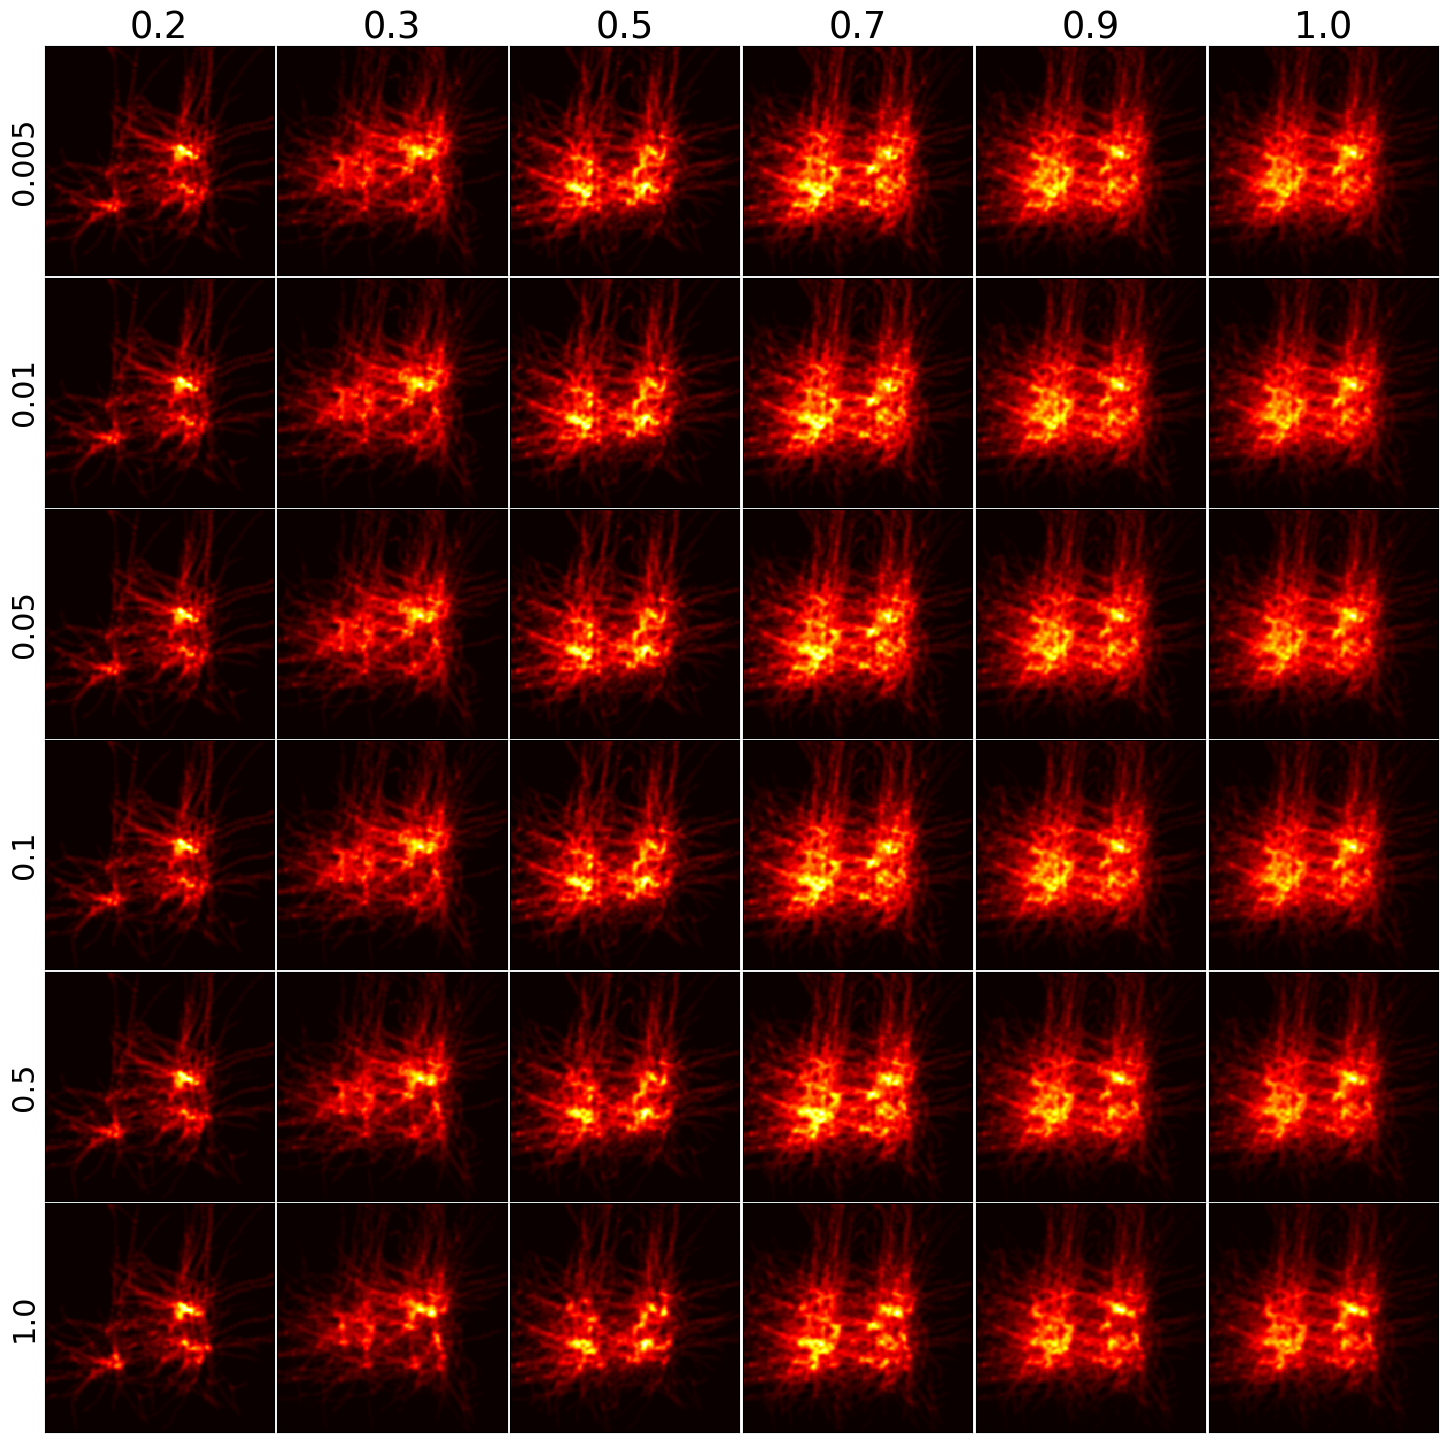

In [13]:
# fontsize 22 params
plt.rcParams.update({'font.size': 22})
# plot all the sparsity_soma_ratio_arr images for each sparsity level x each soma:dend ratio
plt.clf()
plt.figure(figsize=(3 * len(sparsity_range), 3 * len(soma_dend_ratio_range)))
for i_sp in range(len(sparsity_range)):
    for i_sr in range(len(soma_dend_ratio_range)):
        # subplot of len(sparsity_range) x len(soma_dend_ratio_range)

        plt.subplot(len(soma_dend_ratio_range), 
                    len(sparsity_range), 
                    i_sr * len(sparsity_range) + i_sp + 1)
        plt.imshow(sparsity_soma_ratio_arr[i_sp][i_sr][:, :], cmap='hot', interpolation='nearest')
        # no x- y ticks
        plt.xticks([])
        plt.yticks([])
    
        if i_sr == 0:
            plt.title(f"{sparsity_range[i_sp]}")
        if i_sp == 0:
            plt.ylabel(f"{soma_dend_ratio_range[i_sr]}")
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig(output_dir + "sparsity_soma_ratio_arr.png")
plt.show()

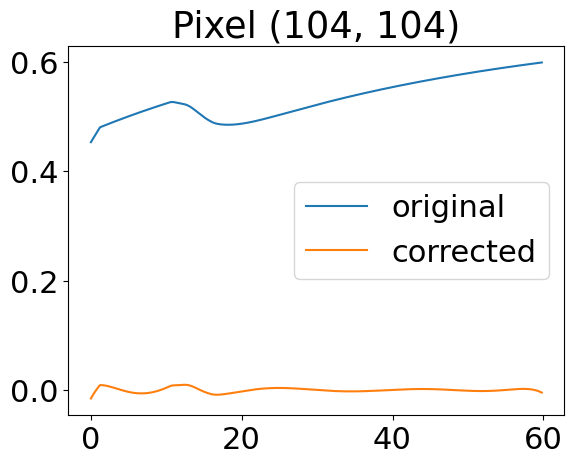

In [14]:
# plot a df/f heatmap of the image
# probably will need baseline correction: fit everything except 25-40 ms window to 
# an 8th-order polynomial and subtract this baseline from the trace
arr_no_soma = -final_arr['blurred_arr']['dend']['syn'] + \
                -final_arr['blurred_arr']['axon']['syn'] + \
                -final_arr['blurred_arr']['apic']['syn']
arr_no_soma = arr_no_soma[100:, :, :]
arr_all = -final_composed_arr['blurred_arr'][400:, :, :]

arr = arr_all
shift = 0
corrected_arr = np.zeros((arr.shape[0] - shift, 
                          arr.shape[1], arr.shape[2]), dtype='float32')

exclusion_window = (25 - shift, 40 - shift)  # ms
bc = BaselineCorrection(exclusion_windows=(exclusion_window,))
for i in range(arr.shape[1]):
    for j in range(arr.shape[2]):
        trace = arr[shift:, i, j]
        # fit a polynomial to the trace (excluding the 25-40 ms window)
        t = np.linspace(shift, (len(trace)-1) * delta_t, len(trace))
        
        corrected_trace = bc.fit_baseline(t, trace)
        corrected_arr[:, i, j] = trace #corrected_trace

        # only plot near the center of the image
        if i in range(cam_width//2, cam_width//2+5) and \
            j in range(cam_height//2, cam_height//2+5):


            plt.clf()
            plt.plot(t, trace, label='original')
            plt.plot(t, corrected_trace, label='corrected')
            #plt.xlim(shift, 60)
            #plt.ylim(-0.5, 1.5)
            plt.title(f"Pixel ({i}, {j})")
            plt.legend()
            if i == 40 and j == 40:
                plt.show()




C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21368\2606054788.py:2: RuntimeWarning: invalid value encountered in true_divide
  df_f = np.max(corrected_arr[:, :, :], axis=0) / np.mean(-final_composed_arr['blurred_arr'], axis=0)


<Figure size 640x480 with 0 Axes>

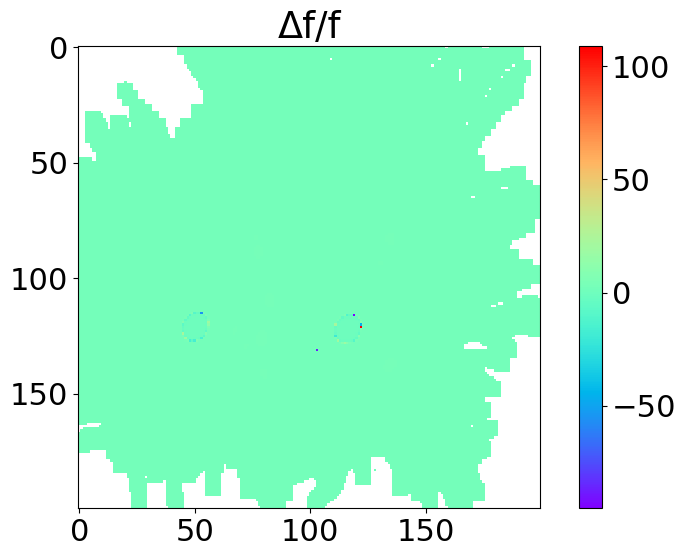

In [15]:

# show the corrected_arr image as heatmap, normalized by resting light
df_f = np.max(corrected_arr[:, :, :], axis=0) / np.mean(-final_composed_arr['blurred_arr'], axis=0)
plt.clf()
plt.figure(figsize=(10, 6))
plt.imshow(df_f, cmap='rainbow', interpolation='nearest')
plt.colorbar()
plt.title(f"Δf/f")
plt.savefig(output_dir + "df_f.png")
plt.show()

In [16]:
for compart_type in final_arr['blurred_arr'].keys():
    np.save(output_dir + f"final_composed_arr_{compart_type}.npy", final_arr['blurred_arr'][compart_type]['syn'])
    print("saved", output_dir + f"final_composed_arr_{compart_type}.npy")

saved C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/final_composed_arr_axon.npy
saved C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/final_composed_arr_dend.npy
saved C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/final_composed_arr_soma.npy
saved C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/final_composed_arr_apic.npy


In [17]:
# save final_composed_arr['blurred_arr'] to a npy file 
np.save(output_dir + "final_composed_arr_blurred.npy", 
        final_composed_arr['blurred_arr'])
# also save 
print("saved files to", output_dir)

saved files to C:/Users/jjudge3/Desktop/neuron docker/composed_results/run13_9/composed_output/


9.34053
2.43255


<Figure size 640x480 with 0 Axes>

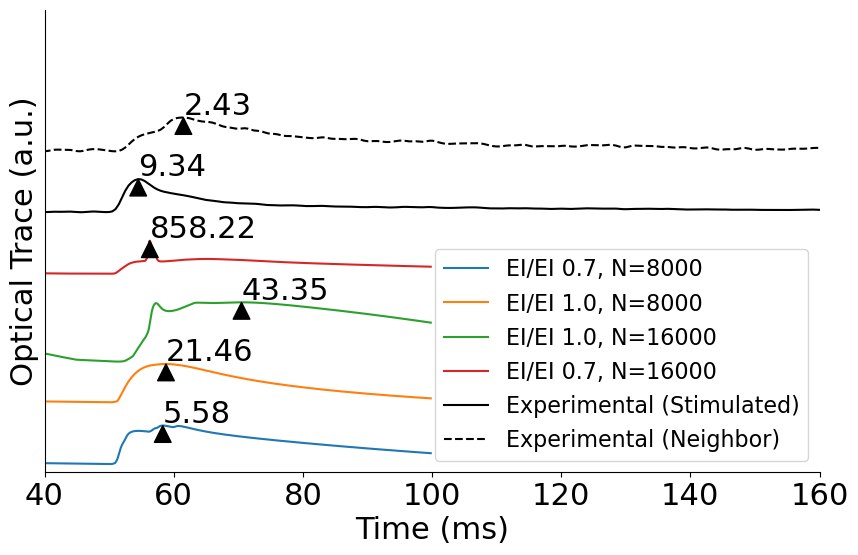

In [18]:
import pandas as pd

data_dir_base = 'P:/John/simulation/in-silico-hVOS/neuron docker/composed_results/'
roi = rois[0]
last_headspace = 0

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

plt.clf()
plt.figure(figsize=(10, 6))

label_text = {'run8_tune4/': 'EI/EI 0.7, N=8000',
                'run8_tune5/': 'EI/EI 1.0, N=8000', 
                'run8_tune7/': 'EI/EI 1.0, N=16000',
                'run8_tune8/': 'EI/EI 0.7, N=16000'}

for data_dir in ['run8_tune4/', 'run8_tune5/', 'run8_tune7/', 'run8_tune8/']:
    arr = data_dir_base + data_dir + 'composed_output/final_composed_arr_blurred.npy'
    arr = -np.load(arr)
    arr[:400, :, :] = 0  # remove the first 400 ms of data

    # now plot the optical trace for the roi
    roi_trace = None
    for px in roi:
        px[0] = min(px[0], arr.shape[1]-1)
        px[1] = min(px[1], arr.shape[2]-1)
        if roi_trace is None:
            roi_trace = arr[:, px[0], px[1]]
        else:
            roi_trace += arr[:, px[0], px[1]]

    roi_trace /= len(roi)

    # normalize the roi_trace by the max value
    max_val = np.max(roi_trace)
    roi_trace = roi_trace / max_val
    plt.plot(time, roi_trace + last_headspace, 
                label=label_text[data_dir],)

    # annotate the trace with the max value
    max_idx = np.argmax(roi_trace)
    
    max_val_plot = roi_trace[max_idx] + last_headspace
    plt.annotate(f"{max_val / 10**8:.2f}", xy=(time[max_idx], max_val_plot), 
                xytext=(time[max_idx], max_val_plot + 0.1),
                arrowprops=dict(facecolor='black', shrink=0.05))

    last_headspace += 2

# add experimental traces to the plot
file = 'P:/John/analyzed_archived/crossing_PPR/crossing_PPR/PPR/PPR_coronal_annotated/01-02-25/converted_zda/_2_2_5_trace_2_rois_pulse1.dat'

traces = read_dat_trace_file(file)
home_max = traces['ROI1'].max() / 2
for r in traces.columns:
    if 'ROI' in r:
        
        max_val = np.max(traces[r])
        traces[r] = traces[r] / max_val
        plt.plot(traces['Pt'] / 2 - 28, traces[r] + last_headspace, 
                    label=('Experimental' + (" (Stimulated)" if r == 'ROI1' else ' (Neighbor)')), color='black',
                    linestyle=('--' if 'ROI2' in r else None))
        print(max_val)
        plt.annotate(f"{max_val:.2f}", xy=(traces['Pt'][traces[r].idxmax()] / 2 - 28, 
                    traces[r].max() + last_headspace), 
                    xytext=(traces['Pt'][traces[r].idxmax()] / 2 - 28, 
                            traces[r].max() + last_headspace + 0.1),
                    arrowprops=dict(facecolor='black', shrink=0.05))
        last_headspace += 2

#turn off spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='lower right', fontsize=16)
plt.xlim(40, 160)
plt.ylim(-0.5, last_headspace + 2.5)
plt.yticks([])
plt.xlabel("Time (ms)")
plt.ylabel("Optical Trace (a.u.)")
plt.savefig(data_dir_base + "roi_traces_across_runs.png")
plt.show()
plt.close()
    
    
    
